## Import libraries

1. `import requests`: This library is used to make HTTP requests. It allows the script to retrieve data from web pages.
2. `import re`: The `re` module is used to provide support for regular expressions, in our case, both pattern matching and text manipulation.
3. `from bs4 import BeautifulSoup`: BeautifulSoup will be used for parsing and navigating the HTML contents retrieved from `bulbapedia`.
4. `from csv import QUOTE_ALL`: This import statement imports the `QUOTE_ALL` constant from the CSV module. 
5. `import pandas as pd`: Pandas is a powerful data manipulation library that will be used for working with structured data.
6. `from time import sleep`: THe `sleep` function from library `time` is imported to act as a pause between requests to bulbapedia.
7. `import seaborn as sns` and `import matplotlib.pyplot as plt` are libraries used for visualization and plottting purposes.

In [22]:
import requests
import re
from bs4 import BeautifulSoup
from csv import QUOTE_ALL
import pandas as pd
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize first relevant values

The following codeblock is to define a Python dictionary named `GAME_INFO`. This dictionary is used to store information about various Pokémon games, including the game's abbreviation  and a section of the URL corresponding to that game on the Bulbapedia website.

- For each game, there are two pieces of information stored as key-value pairs:
  - The game's abbreviation as are listed in the different tables in `bulbapedia`.
  - An "url" segment, which represents a section of the URL on the Bulbapedia website associated with the locations for that game.

Here's an example of how it works:
- For the game "Black & White," the abbreviation "BW" is used as a key in the dictionary.
- The corresponding URL section is "Black_and_White," which would be part of the complete URL on Bulbapedia.
- The games themselves are stored as a tuple with abbreviations, like ("B\xa0", "W\xa0") *.

* **NOTE: *\xa0* is a non-breaking space character used as a separator in `bulbapedia`.**

In [23]:
GAME_INFO = {
    "BW": {"url": "Black_and_White", "games": ("B\xa0", "W\xa0")},
    "HGSS": {"url": "HeartGold_and_SoulSilver", "games": ("HG\xa0", "SS\xa0")},
    "E": {"url": "Emerald", "games": ("E\xa0",)},
    "P": {"url": "Platinum", "games": ("Pt\xa0",)},
    "FRLG": {"url": "FireRed_and_LeafGreen", "games": ("FR\xa0", "LG\xa0")},
}

## Pokemon Item Data Retrieval

This Python code defines a function `get_item_dataframes` designed to retrieve item data from various Pokémon games on the Bulbapedia website. The function is structured as follows:

1. **Game Information Setup**: It begins by setting up game-related information, including the game's abbreviation, corresponding URL, and shorthand notations used in games. It checks if the specified game is valid, and if not, it raises an error.
2. **URL Retrieval and Parsing**: The code constructs a URL for the specified game's location list page on Bulbapedia, sends a GET request to that URL, and parses the content using BeautifulSoup. If the request is unsuccessful, an error is raised.
3. **Location List Extraction**: The function extracts the list of locations for the game from the parsed HTML content. It stores this information in a list of tuples, where each tuple contains the location name and URL.
4. **Data Retrieval for Each Location**: For each location, the code sends a new GET request to the location's URL, parses the content, and retrieves item data from tables. It uses specific table headers (Item, Location, Games) to identify relevant data.
5. **Data Processing**: The item data is processed, and any rows with game abbreviations not matching the specified game are excluded. Non-breaking spaces are replaced with vertical bars, and rows are split if items appear in multiple places within the same location.
6. **DataFrame Creation**: For each location's item data, a pandas DataFrame is created. These DataFrames are stored in a list.
7. **Status Updates**: As the code processes each location, it provides status updates, indicating the progress of location checking. A delay of 1.5 seconds is introduced between requests to avoid overloading the server.
8. **Concatenation**: After processing all locations, the DataFrames are concatenated into a single DataFrame.
9. **Result**: The final concatenated DataFrame, containing item data for the specified game, is returned by the function.

In [24]:
def get_item_dataframes(game=None):
    # Define the base Bulbapedia URL
    bulbapedia_url = "https://bulbapedia.bulbagarden.net"
    
    # Get the list of available games and associated information
    game_list = GAME_INFO.keys()
    game_url = GAME_INFO[game]["url"]
    game_abbreviations = GAME_INFO[game]["games"]

    # Check if the specified game is valid
    if game not in game_list:
        raise ValueError(f"{game} is not a valid game. Choose one of {', '.join(game_list)}")

    # Create the URL for the game's location list page
    location_list_url = f"https://bulbapedia.bulbagarden.net/wiki/Category:{game_url}_locations"
    url_request = requests.get(location_list_url)
    
    # Check if the URL request was successful
    if url_request.status_code != 200:
        raise ValueError(f"Request to '{location_list_url} wasn't sucessful.'")

    # Retrieve the content of the location list page and parse it with BeautifulSoup
    url_content = url_request.content
    bs4_content = BeautifulSoup(url_content)
    
    # Find all category group tags containing location information
    category_group_tags = bs4_content.find_all("div", {"class": "mw-category-group"})

    # Initialize an empty list to store item location data
    location_list = []

    # Iterate through each category group
    for category_group_tag in category_group_tags:
        # Find the list items under the h3 header
        li_tags = category_group_tag.find_next("h3").find_next("ul").find_all("li")
        for li_tag in li_tags:
            a_tag = li_tag.find_next("a")
            # Store location information as a tuple (name, URL)
            location_list.append((a_tag["title"], a_tag["href"]))

    print(f"Request to retrieve list of locations for url '{location_list_url} returned {len(location_list)} items.'")

    # Initialize an empty list to store DataFrames
    df_list = []

    # Iterate through each location tuple and retrieve item data from the corresponding url
    for i, location_tuple in enumerate(location_list):
        location_name = location_tuple[0]
        location_url = bulbapedia_url + location_tuple[1]
        location_url_request = requests.get(location_url)
        
        # Check if the URL request for the specific location was successful
        if location_url_request.status_code != 200:
            continue  # Skip this location and continue with the next one
        
        # Retrieve and parse the content of the location's page
        url_content = location_url_request.content
        bs4_content = BeautifulSoup(url_content)

        # Find all tables on the location's page
        tables = bs4_content.find_all("tbody")
        
        # Iterate through each table to find item data
        for table in tables:
            # Ignore all tables that don't have the following headers: Item, Location, Games
            if not table.find("th", string="Item\n"):
                continue
            if not table.find("th", string="Location\n"):
                continue
            if not table.find("th", string="Games\n"):
                continue
            table_data_rows = table.find_all("tr")
            # Set the headers for the table
            table_headers = [th.text.strip().lower() for th in table.find_all("th")]
            table_headers.append("location_general")
            # Initialize an empty list to store row values
            table_rows = []

            # Extract data for each item and its location except the first element,
            # this is to exclude the cell that contains the image for the item
            for row in table_data_rows:
                table_data = row.find_all("td")
                try:
                    _, item, location, games = [td for td in table_data]
                except ValueError:
                    continue
                # Some locations might have data about other generations,
                # to exclude them we make sure we the correct abbreviations are in the fourth column
                if all(
                    abbreviation not in games.text
                    for abbreviation in game_abbreviations
                ):
                    continue
                
                # Replace the nonlinebreaking spaces with vertical bars
                games = re.sub(r"\xa0+", "|", games.text.strip())
                
                # Some items might appear multiple times in different places in the same location,
                # in those cases, we split the row in multiple rows
                split_row = False
                item = item.text.strip()
                if re.search(r"×\d", item):
                    item = re.sub(r"×\d+", "", item).strip()
                    split_row = True
                location = location.text.strip()

                # Split the row if necessary and append all the resulting row to table_rows
                if split_row:
                    table_row_split = [
                        (item, location.strip(), games, location_name)
                        for location in location.split("\n")
                    ]
                    table_rows.extend(table_row_split)
                else:
                    table_row = (item, location, games, location_name)
                    table_rows.append(table_row)

            # Create a DataFrame for this location's item data
            df_list.append(pd.DataFrame(table_rows, columns=table_headers))

        # Wait 1.5 seconds
        sleep(1.5)

    # Concatenate all DataFrames into a single DataFrame
    general_df = pd.concat([df for df in df_list], ignore_index=True)
    
    # Return the final concatenated DataFrame
    return general_df

## Pokémon Item Data Aggregation and Export

This Python code block is responsible for aggregating item data from multiple Pokémon games, provided through the `GAME_INFO` dictionary. It combines the data into a single DataFrame and exports it to a CSV file. Here's the breakdown of its functionality:

1. **DataFrame List Initialization**: An empty list named `dataframe_list` is created to store DataFrames.
2. **Data Retrieval Loop**: The code iterates through each game defined in the `GAME_INFO` dictionary using `for game in GAME_INFO.keys():`. For each game, it calls the `get_item_dataframes` function to retrieve item data specific to that game. The resulting DataFrame is stored in the `region_dataframe` variable.
3. **Dataframe Collection**: Each `region_dataframe` is appended to the `dataframe_list`, effectively collecting all the DataFrames for each game.
4. **Concatenation**: The code uses the `pd.concat` function to combine all the DataFrames in the `dataframe_list` into a single DataFrame named `full_dataframe`. The `ignore_index=True` parameter ensures that the index of the resulting DataFrame is reset.
5. **CSV Export**: The final aggregated DataFrame, `full_dataframe`, is exported to a CSV file named "fullset_dataframe.csv." Several parameters are specified for the CSV export:
   - `index=False`: Ensures that the index column is not included in the exported CSV.
   - `encoding="utf8"`: Specifies the character encoding.
   - `sep=";"`: Sets the column separator in the CSV to a semicolon.
   - `quoting=QUOTE_ALL`: Quotes all fields in the CSV to preserve special characters.

**Note: Keep in mind this codeblock takes a while to run, so to avoid rerunning the function unnecesarily multiple times. We check if the file already exists or not.**

In [25]:
try:
    full_dataframe = pd.read_csv("fullset_dataframe.csv", encoding="utf8", delimiter=";")
except FileNotFoundError:
    dataframe_list = []
    for game in GAME_INFO.keys():
        region_dataframe = get_item_dataframes(game=game)
        dataframe_list.append(region_dataframe)

    full_dataframe = pd.concat([df for df in dataframe_list], ignore_index=True)
    full_dataframe.to_csv(
        "fullset_dataframe.csv", index=False, encoding="utf8", sep=";", quoting=QUOTE_ALL
    )

# Data Processing and Filtering

This code block is responsible for processing and filtering item location data obtained from Bulbapedia to prepare it for further analysis. It involves several steps:

1. **Exclusion of Unavailable Mechanics:**
   - In the Unova main games, certain items can appear in dust clouds or the shadows of flying Pokémon. However, these mechanics are not available in PokeMMO. Therefore, the code filters out any rows that mention "Dust Cloud" or "Flying Pokémon's shadow" as locations. The same logic is applied to items found by smashing rocks.
2. **Adjustment for Game Regions:**
   - In PokeMMO, the Kanto region is not accessible in HeartGold and SoulSilver as in the main games. To correct this, the code filters out rows that have "HG" or "SS" in the 'games' column but do not have "FR" or "LG."
3. **Region Classification:**
   - A new column 'region' is created to categorize item locations based on the 'games' column. Locations are classified into regions Kanto, Hoenn, Johto, Sinnoh, Unova, or 'Other' depending on the game abbreviation in the 'games' column.
4. **Identification of Hidden Items:**
   - Another new column 'hidden' is added to mark items that have "(hidden)" in their location description. This helps in distinguishing hidden items.
5. **Data Inspection:**
   - Finally, the code displays the first 5 rows of the modified DataFrame for initial inspection.

This code prepares the item location data for further analysis by cleaning and categorizing it according to game regions and hidden items, ensuring it is well-structured and free from irrelevant information.

In [26]:
# First we drop duplicates if there is any
full_dataframe = full_dataframe.drop_duplicates()

# Exclude items that appear in dust clouds or flying Pokémon's shadows in the Unova main games,
# as these mechanics are not available in PokeMMO.
full_dataframe = full_dataframe[~full_dataframe["location"].isin(["Dust cloud", "Flying Pokémon's shadow"])]
# Exclude items that appear by smashing rocks
full_dataframe = full_dataframe[~full_dataframe["location"].str.contains('Found by smashing breakable rocks')]

# Correct for the inaccessibility of the Kanto region in the HeartGold and SoulSilver games in PokeMMO,
# by eliminatin any overlap between Kanto and Johto main games that have HG or SS in 'games', but not FR or LG.
full_dataframe = full_dataframe[~((full_dataframe['games'].isin(['HG', 'SS'])) & ~(full_dataframe['games'].isin(['FR', 'LG'])))]

# Create a new column 'region' to categorize locations based on the 'games' column.
def classify_region(games):
    games = games.split("|")
    if 'FR' in games or 'LG' in games:
        return 'Kanto'
    elif 'E' in games:
        return 'Hoenn'
    elif 'HG' in games or 'SS' in games:
        return 'Johto'
    elif 'Pt' in games:
        return 'Sinnoh'
    elif 'B' in games or 'W' in games:
        return 'Unova'
    else:
        return 'Other'

full_dataframe['region'] = full_dataframe['games'].apply(classify_region)

# Create a new column 'hidden' to mark items with '(hidden)' in their location description.
full_dataframe['hidden'] = full_dataframe['location'].str.contains('\(hidden\)')

# Display the first 5 rows of the modified DataFrame.
full_dataframe.head()


,item,location,games,location_general,region,hidden
0,TM35 (Flamethrower),West of the house near the entrance,B|W,Abundant Shrine,Unova,False
1,BalmMushroom,On the northern bank of the pond west of the h...,B|W,Abundant Shrine,Unova,True
2,Hyper Potion,Northeast of Youngster Wes,B|W,Abundant Shrine,Unova,False
3,TinyMushroom,North of Youngster Wes (hidden),B|W,Abundant Shrine,Unova,True
4,TinyMushroom,Southwest of Lass Lurleen (hidden),B|W,Abundant Shrine,Unova,True


## Categorizing Valuable Items in Pokémon Games

This code block is part of a broader task that aims to determine the value of items that can be obtained by completing all regions in an alternate Pokémon account. It involves categorizing different items into specific groups to better understand their significance within the games.

1. **Defining Valuable Item Categories**
   - `ITEM_CATEGORY` is a dictionary that defines various categories of valuable items found in Pokémon games. Each category contains a list of items belonging to that category.
   - Categories include Evolution Stones, Held Items for Evolution, Valuable Items for Sale, Vitamins, Herbal Medicines, Type-Enhancing Items, and Other Valuable Items that don't fit the previous categories.
2. **Data Preprocessing**
   - To ensure consistency, the code removes spaces and converts item names to lowercase within each category.
3. **Combining Items into a Single List**
   - The code combines all valuable items from different categories into a single list named `all_valuable_items`.
4. **Categorization Function**
   - A function named `categorize_item` is defined to categorize each item based on its name. It checks if an item belongs to one of the predefined categories or falls into a specific pattern (e.g., TMs/HMs or Berries).
   - The function assigns a category label to each item, such as 'Evolution Stone', 'Held Item for Evolution', 'Valuable Item for Sale', 'Vitamin', 'Herbal Medicine', 'Type Enhancing Item', 'Other Item', 'TM/HM', 'Berry', or 'Uncategorized'.
5. **Applying Categorization to Dataframe**
   - The code applies the `categorize_item` function to the items in the 'item' column and creates a new column called 'item_category' to store the assigned category labels.

This code is a critical step in the process of analyzing valuable items in the context of completing different regions in Pokémon games. It organizes items into meaningful categories, making it easier to evaluate their significance in the games.


In [27]:
# I'm interested in knowing how many valuable items I can get by completing all regions in an alt account

# We create a list of dictionaries that categorizes different items that we consider as valuable in the games
ITEM_CATEGORY = {
"evolution_stones" : [
    "Fire Stone", "Water Stone", "Thunder Stone", "Leaf Stone", "Moon Stone",
    "Sun Stone", "Shiny Stone", "Dusk Stone", "Dawn Stone", "Ice Stone"
],
"held_items_for_evolution" : [
    "Deep Sea Scale", "Deep Sea Tooth", "Dragon Scale", "Dubious Disc", "Electirizer",
    "King's Rock", "Magmarizer", "Metal Coat", "Oval Stone", "Prism Scale",
    "Protector", "Razor Claw", "Razor Fang", "Reaper Cloth", "Sachet", "Upgrade"
],
"valuable_items_for_sale" : [
    "Nugget", "Big Mushroom", "Big Pearl", "Brick Piece", "Gold Leaf",
    "Pearl", "Silver Leaf", "Slowpoke Tail", "Star Piece", "Stardust",
    "Tiny Mushroom", "Blue Shard", "Green Shard", "Red Shard", "Shoal Salt",
    "Shoal Shell", "Yellow Shard", "Rare Bone", "Balm Mushroom", "Big Nugget",
    "Comet Shard", "Pearl String"
],
"vitamins" : [
    "HP Up", "Protein", "Iron", "Calcium", "Zinc", "Carbos", "PP Up", "PP Max"
],
"herbal_medicines" : [
    "Heal Powder", "Energy Powder", "Energy Root", "Revival Herb"
],
"type_enhancing_items" : [
    "Black Belt", "Black Glasses", "Charcoal",
    "Dragon Fang", "Fairy Feather", "Hard Stone",
    "Magnet", "Metal Coat", "Miracle Seed",
    "Mystic Water", "Never-Melt Ice", "Pink Bow",
    "Poison Barb", "Polkadot Bow", "Sharp Beak",
    "Silk Scarf", "Silver Powder", "Soft Sand",
    "Spell Tag", "Twisted Spoon"
],
"other_items" : [
    "Amulet Coin", "Choice Band", "Choice Specs", "Choice Scarf", "Expert Belt", 
    "Flame Orb", "Toxic Orb", "Iron Ball", "King's Rock", "Lagging Tail",
    "Metronome", "Wide Lens", "Wise Glasses", "Zoom Lens"
]
}

# Remove spaces and convert item names to lowercase for consistency, this will help when making comparisons with the dataframe
ITEM_CATEGORY = {key: [item.lower().replace(" ", "") for item in value] for key, value in ITEM_CATEGORY.items()}

# Combine all valuable items into a single list
all_valuable_items = [item for item_list in ITEM_CATEGORY.values() for item in item_list]

# Create a function to categorize different items
def categorize_item(x):
    if x.lower().replace(" ", "") in ITEM_CATEGORY["evolution_stones"]:
        return 'Evolution Stone'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["held_items_for_evolution"]:
        return 'Held Item for Evolution'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["valuable_items_for_sale"]:
        return 'Valuable Item for Sale'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["vitamins"]:
        return 'Vitamin'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["herbal_medicines"]:
        return 'Herbal Medicine'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["type_enhancing_items"]:
        return 'Type Enhancing Item'
    elif x.lower().replace(" ", "") in ITEM_CATEGORY["other_items"]:
        return 'Other Item'
    elif re.match("^(TM|HM)\d{2}\s\(.+\)", x):
        return 'TM/HM'
    elif re.match("^\w+\sBerry$", x):
        return 'Berry'
    else:
        return 'Uncategorized'
    
# Apply the categorization function to create a new 'item_category' column in the dataframe
full_dataframe['item_category'] = full_dataframe['item'].apply(categorize_item)

The following code is a continuation of the previous step. It processes and visualizes data related to valuable items in the regions:

1. **Data Filtering**: The DataFrame is filtered to include only rows where the item is in the list of valuable items. This is done to focus only on relevant data.
2. **Pivoting Data**: The filtered DataFrame is pivoted to obtain counts of item categories per region. The resulting table provides a summary of how many items of each category are found in each region.
3. **Total Column**: An additional 'Total' column is added to the DataFrame to calculate the sum of counts for each region, providing an overall count of valuable items.
4. **Creating a Heatmap**: A heatmap is generated using Seaborn. This heatmap visually represents the counts of item categories per region, with different colors indicating item category counts.
5. **Customizing Labels**: The plot's labels and appearance are customized. The x-axis is labeled as 'Item Categories,' and the y-axis is labeled as 'Regions.' The plot is styled with a dark grid background and a specified color map.
6. **Displaying the Plot**: The final heatmap plot is displayed using the `plt.show()` function.

This code helps analyze and visualize valuable item data across different regions, providing insights into the distribution of these


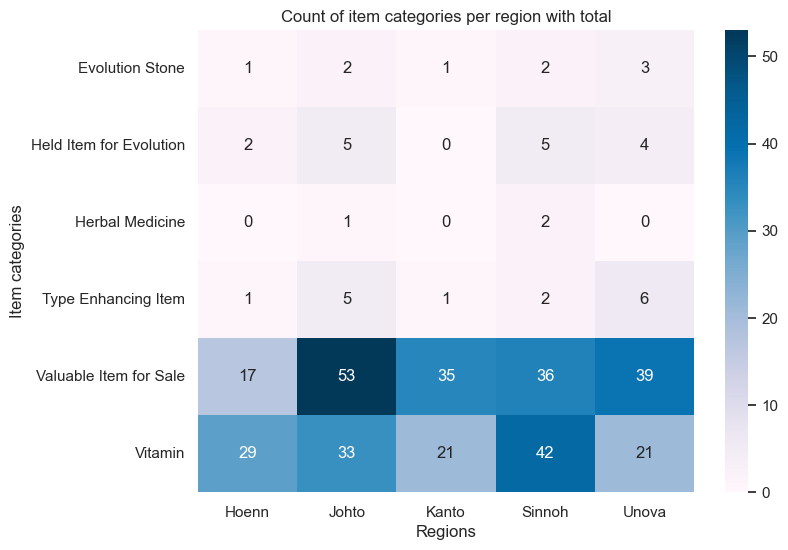

In [28]:
# Filter the DataFrame to select only rows where the item is in the list of valuable items
valuable_items_df = full_dataframe[full_dataframe["item"].str.lower().replace(" ", "").isin(all_valuable_items)]

# Pivot the DataFrame to calculate the counts of item categories per region
pivot_df = valuable_items_df.pivot_table(index='region', columns='item_category', aggfunc='size', fill_value=0)

# Create a heatmap using Seaborn for visualization
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
plt.title('Count of item categories per region with total')

# Customize labels and display the heatmap, while trasposing result for better readability
sns.heatmap(pivot_df.T, annot=True, fmt="d", cmap="PuBu", cbar=True, xticklabels='auto', yticklabels='auto')
plt.ylabel('Item categories')
plt.xlabel('Regions')

plt.show()

## Comparing the most common valuable items

The following code and barplts are designed to create a set of bar charts to visualize and compare the most common valuable items in different regions. 

Here's a step-by-step explanation of what the code does:

1. **Get Unique Regions**: It starts by extracting the unique values in the "region" column from a DataFrame named `valuable_items_df`. These regions will be used as the categories for the charts.
2. **Create Subplots**: It sets up a subplot layout with as many columns as there are unique regions. This allows multiple charts to be displayed side by side.
3. **Iterate Through Regions**: It iterates through each unique region and performs the following steps for each one:
    a. **Filter Data for the Region**: It filters the original DataFrame to get only the rows that match the current region.
    b. **Find the Top 5 Items**: It calculates the top 5 most common items in the region by counting the occurrences of each item in that subset of the data.
    c. **Create a Barplot**: It creates a bar chart for the current region using Seaborn. The x-axis represents the counts of the top items, while the y-axis shows the item names. The `hue` parameter seems to be set to the item names, but it may not be used in this context, as `legend` is set to `False`.
5. **Adjust Subplot Spacing**: It adjusts the spacing between subplots to ensure that they don't overlap.
6. **Show the Combined Chart**: Finally, it displays the combined chart with all the subplots.

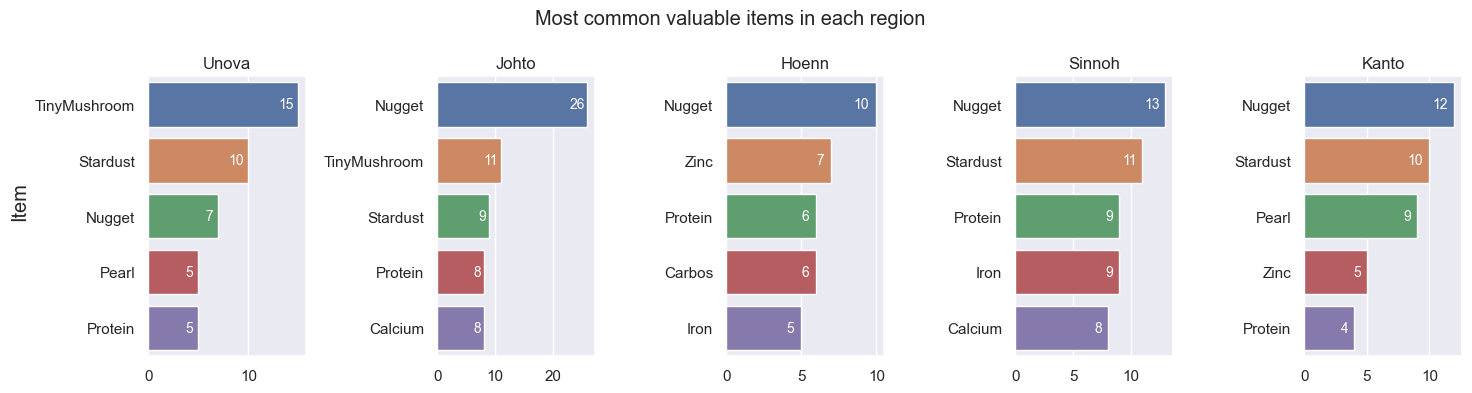

In [29]:
# Get the list of unique regions
unique_regions = valuable_items_df["region"].unique()

# Create subplots to display charts side by side
fig, axes = plt.subplots(1, len(unique_regions), figsize=(15, 4))

fig.suptitle("Most common valuable items in each region")
fig.supylabel("Item")

# Iterate through each region and create a barplot
for i, region in enumerate(unique_regions):
    region_df = valuable_items_df[valuable_items_df["region"] == region]
    
    # Get the 5 most common items in the region
    top_items = region_df["item"].value_counts().head(5)
    
    # Create a barplot for the current region
    sns.barplot(x=top_items.values, y=top_items.index, ax=axes[i], hue=top_items.index, legend=False)
    axes[i].set_title(region)
    axes[i].set_ylabel("")
    for index, value in enumerate(top_items):
        axes[i].text(x=value-0.5, y=index, s=str(value), color="white", ha="right", va="center", fontsize=10)
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the combined chart
plt.show()

## Analyzing the Number of TM Obtainable by completing all regions

In this analysis, we aim to determine the total count of Technical Machines (TMs) that can be acquired by completing all regions in an alternate account. To achieve this, we will take the following steps:

1. **Data Filtering:** We will filter the item data in the DataFrame to isolate TM and HM items. These items typically have names in the format "TM## (Move Name)" where '##' represents a two-digit number.
2. **Counting by Region:** After filtering, we will calculate the count of TM items available in each region. This count will help us understand the distribution of these valuable items across various regions.
3. **Data Visualization:** To better visualize the distribution, we will create a barplot. Each region will be represented on the x-axis, and the corresponding count of TM items will be displayed on the y-axis.

This analysis will provide insights into the availability of TM/HMs across different regions, aiding in strategic planning for an alternate account. The barplot will make it easy to compare the number of TM items obtainable in each region.

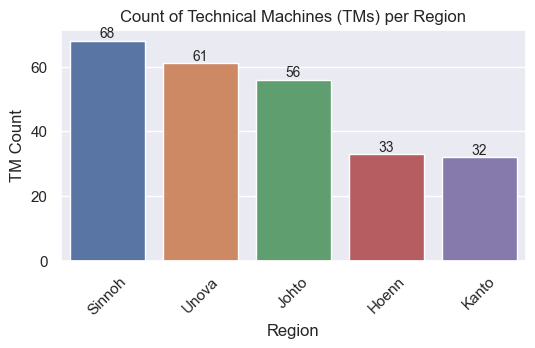

In [30]:
# Calculate the number of Technical Machines (TMs) obtainable by completing all regions in an alternate account
tms = full_dataframe[full_dataframe['item'].str.contains("TM\d\d \(.*\)", regex=True)]

# Count of TMs available in each region
region_counts = tms["region"].value_counts()

# Create a barplot to visualize the distribution of TMs per region
plt.figure(figsize=(6, 3)) 
barplot = sns.barplot(x=region_counts.index, y=region_counts.values, hue=region_counts.index, legend=False)
plt.title("Count of Technical Machines (TMs) per Region")
plt.xlabel("Region")
plt.ylabel("TM Count")

# Add labels to the bars to display the precise TM counts
for index, value in enumerate(region_counts):
    barplot.text(index, value, str(value), ha="center", va="bottom", fontsize=10)

# Display the barplot with rotated x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()